In [1]:
pip install duckdb pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import duckdb
import pandas as pd

db_path = './load-testing-sample.duckdb'

con = duckdb.connect(database=db_path)

# 데이터베이스의 모든 테이블 목록 가져오기
tables = con.execute("SHOW TABLES").fetchall()
print("Tables in database:", tables)

Tables in database: [('metrics',)]


In [3]:
pd.options.display.float_format = '{:.5f}'.format

In [4]:
table_name = 'metrics'
df = con.execute(f"SELECT * FROM {table_name}").fetchdf()

# DataFrame 출력
print(df)

                 timestamp    network_in   requests  num_of_instances  \
0      2024-05-30 09:20:42   11755.62012    0.00000                 1   
1      2024-05-30 09:20:47    4123.50098    0.00000                 1   
2      2024-05-30 09:20:53    3346.76367    0.00000                 1   
3      2024-05-30 09:20:58    4049.43872    0.00000                 1   
4      2024-05-30 09:21:03    3624.60693    0.00000                 1   
...                    ...           ...        ...               ...   
712248 2024-06-04 06:20:28 3268923.00000 1834.79272                 7   
712249 2024-06-04 06:20:33 3430668.75000 1809.18311                 7   
712250 2024-06-04 06:20:38 3623121.50000 1946.67810                 7   
712251 2024-06-04 06:20:43 4124254.75000 2169.24146                 7   
712252 2024-06-04 06:20:48 4057447.50000 2275.87012                 9   

        cpu_core_request      cpu  latency  
0                4.20000  0.00787      NaN  
1                4.20000  0.00685

In [5]:
df.dropna(subset=['network_in', 'cpu'], inplace=True)  # 결측치 제거

In [6]:
X = df[['network_in']].values
y = df['cpu'].values

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [10]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [11]:
score = model.score(X_test, y_test)
print(f'Model R^2 score: {score}')

Model R^2 score: 0.8206756493692103


In [12]:
y_pred = model.predict(X_test)

In [13]:
new_network_in = np.array([[500000], [1000000], [20000000]])  # interpolation과 extrapolation 예시
new_network_in_scaled = scaler.transform(new_network_in)
predicted_cpu = model.predict(new_network_in_scaled)

In [14]:
for ni, cpu in zip(new_network_in.flatten(), predicted_cpu):
    print(f'Network in: {ni}, Predicted CPU: {cpu}')

Network in: 500000, Predicted CPU: 2.236097972523599
Network in: 1000000, Predicted CPU: 2.217164539019267
Network in: 20000000, Predicted CPU: 50.40215911865234


In [15]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

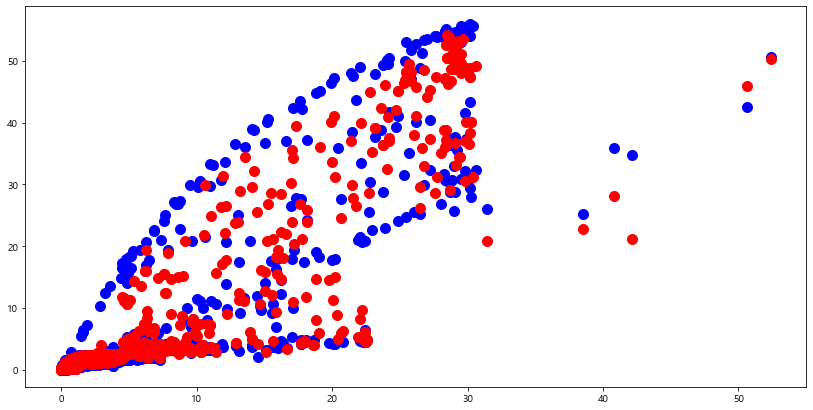

In [16]:
plt.figure(figsize=(14, 7))
plt.scatter(X_test, y_test, color='blue', label='Actual data', s=100)
plt.scatter(X_test, y_pred, color='red', label='Predicted data', s=100)

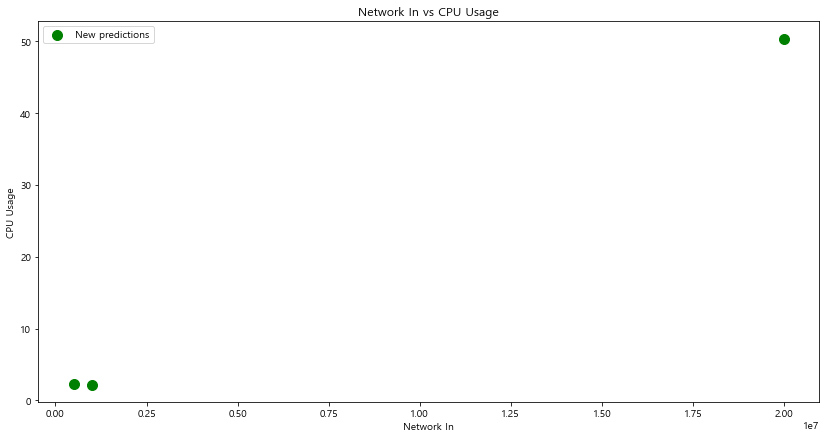

In [17]:
plt.figure(figsize=(14, 7))
plt.scatter(new_network_in, predicted_cpu, color='green', label='New predictions', s=100)
plt.xlabel('Network In')
plt.ylabel('CPU Usage')
plt.title('Network In vs CPU Usage')
plt.legend()
plt.show()

첫 번째 플롯 (실제 값 vs 예측 값)
파란색 점: 실제 데이터 (테스트 데이터셋)
빨간색 점: 모델의 예측 값
이 플롯은 모델이 학습된 데이터 범위 내에서 network_in 값을 입력으로 받아 cpu 값을 얼마나 잘 예측하는지를 보여줍니다. 이상적으로는 빨간색 점(예측 값)과 파란색 점(실제 값)이 겹치거나 가까워야 합니다.

해석:

대부분의 경우 모델의 예측 값(빨간색 점)은 실제 값(파란색 점)과 잘 일치합니다.
일부 점에서는 예측 값이 실제 값과 약간 차이가 나는 것을 볼 수 있습니다.
전반적으로 모델이 데이터의 패턴을 잘 학습하여 예측하고 있음을 보여줍니다.
두 번째 플롯 (새로운 예측 값)
녹색 점: 새로운 network_in 값에 대한 예측 값 (Interpolation과 Extrapolation)
이 플롯은 새로운 network_in 값(500,000, 1,000,000, 20,000,000)에 대해 모델이 cpu 값을 어떻게 예측하는지를 보여줍니다. 여기서 중요한 것은 두 개의 값을 학습 데이터 범위 내에서, 하나의 값을 학습 데이터 범위 밖에서 예측하는 것입니다.

해석:

500,000과 1,000,000은 학습 데이터 범위 내의 값으로, 모델이 예측한 cpu 값은 매우 낮은 값을 가리킵니다.
20,000,000은 학습 데이터 범위를 벗어난 값으로, 모델이 예측한 cpu 값이 높은 값을 가리키고 있습니다.
이 플롯에서는 데이터 분포가 왼쪽 하단에 집중되어 있기 때문에, 새로운 값에 대한 예측이 분포에서 벗어나게 보입니다. 학습 데이터의 대부분이 낮은 network_in 값에 집중되어 있어, 고차원의 값을 예측할 때 모델의 신뢰도가 떨어질 수 있습니다.
종합적인 해석
Interpolation: 학습 데이터 범위 내에서 모델의 예측은 신뢰할 만하며, 실제 값과 잘 일치합니다.
Extrapolation: 학습 데이터 범위를 벗어난 경우, 모델의 예측이 불확실할 수 있으며, 고차원의 값을 예측할 때 예측 오차가 커질 가능성이 있습니다.
추가적으로, 모델의 성능을 향상시키기 위해 다음을 고려할 수 있습니다:

더 많은 데이터를 수집하여 학습 데이터의 다양성을 높입니다.
비선형성을 더 잘 반영할 수 있는 모델을 사용합니다 (예: 딥러닝 모델, 앙상블 모델 등).
모델의 하이퍼파라미터를 최적화하여 성능을 개선합니다.